# Data analysis - `keras`

In [ ]:
import os
import numpy as np
import pickle
import nibabel as nb
import pandas as pd
from scipy.stats import zscore
from keras import layers, models, optimizers, regularizers
from random import shuffle

/home/line/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Create dataset

In [ ]:
def read_dataset(filename, outlier_thr=5):

    # Read csv file
    df = pd.read_csv(filename)

    # extract relevant variables
    sub_id = np.array(df['PAC_ID'])
    label = np.array(df['Label'] - 1)
    df = df.drop(['PAC_ID', 'Label'], 1)
    header = df.keys()
    
    # Clean dataset - drop subjects with values above `outlier_thr` STD
    outliers = np.sum((np.abs(zscore(df)) > outlier_thr), 1) != 0
    print('%d outliers detected.' % outliers.sum())
    data = np.array(df.drop(np.where(outliers)[0]))
    sub_id = sub_id[np.invert(outliers)]
    label = label[np.invert(outliers)]
    
    # zscore data
    data = zscore(data)

    # Reset Gender and Scanner values to nominal values
    data[:,1] = (data[:,1]>0) + 1
    data[:,3] = [np.where(i==np.unique(data[:,3]))[0][0] + 1for i in data[:,3]]

    return pd.DataFrame(data, columns=header), sub_id, label

In [ ]:
data, sub_id, label = read_dataset('data/PAC2018_Covariates_detailed.csv', outlier_thr=5)
data.head()

8 outliers detected.


,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,Left_Frontal_Pole,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1.610405,1.0,1.479924,2.0,-0.890455,1.091014,1.080367,1.034026,0.060878,1.096927,...,1.093750,1.094903,1.037705,-0.896948,-0.255150,-0.724690,-0.269052,1.791264,1.591691,0.091529
1,-1.146076,1.0,-0.052883,1.0,1.134709,-0.118805,-0.147065,0.290905,0.904814,0.017488,...,-0.060199,-0.013714,0.079673,0.634875,1.097503,0.176912,-0.143525,0.223282,0.283818,-0.110870
2,-0.200997,2.0,-0.322187,2.0,-0.910314,0.213228,0.466651,-0.390523,0.488056,-0.281768,...,0.167886,0.162364,0.443724,0.107536,-0.337023,-0.458773,-0.199329,0.879846,0.603997,0.182364
3,-0.200997,1.0,1.526994,3.0,-0.888128,1.178024,1.141739,1.173458,0.863138,0.754654,...,1.022908,1.000870,2.157792,1.573471,2.835140,1.080137,0.815276,0.185643,0.730864,2.010200
4,2.004188,2.0,-0.934370,1.0,1.027570,-2.074238,-2.049584,-2.070608,-0.824733,-2.118870,...,-2.148225,-2.165083,-1.193547,-1.593558,-2.270355,-1.290505,-1.337832,-1.919742,-2.127827,-1.856324


# Create dataset (select dataset, balance it and divide train and validation)

In [ ]:
def balance_dataset(sub_id, labels, data):
    max_label_size = np.min([np.sum(lab == labels) 
                             for lab in np.unique(labels)])

    labels_1 = np.where(labels == 0)[0]
    np.random.shuffle(labels_1)
    labels_1 = labels_1[:max_label_size]

    labels_2 = np.where(labels == 1)[0]
    np.random.shuffle(labels_2)
    labels_2 = labels_2[:max_label_size]

    new_data_id = np.hstack((labels_1, labels_2))
    np.random.shuffle(new_data_id)
    labels = labels[new_data_id]
    sub_id = sub_id[new_data_id]
    data = data[new_data_id]

    return (sub_id, labels, data)

In [ ]:
def get_train_valid_set(sub_id, label, data, group='123', train_ratio=0.8):
    
    selecter = [str(int(d)) in group for d in data.Scanner]

    group_sub, group_label, group_data = balance_dataset(
        sub_id[selecter], label[selecter], np.array(data[selecter]))
    
    
    train_size = int(len(group_sub) * train_ratio)
    valid_size = len(group_sub) - train_size

    counter1 = 0
    counter2 = 0
    train_list = []

    for i, s in enumerate(group_sub):
        if counter1 < (train_size / 2) and group_label[i] == 0:
            train_list.append(s)
            counter1 += 1
        elif counter2 < (train_size / 2) and group_label[i] == 1:
            train_list.append(s)
            counter2 += 1

    selecter = np.array([True if e in train_list else False for i, e in enumerate(group_sub)])

    train_list = group_sub[selecter]
    valid_list = group_sub[np.invert(selecter)]
    
    return train_list, valid_list, group_sub, group_label, group_data

# `Keras` model

In [ ]:
def data_gen(fileList, batch):

    while True:
        for r in range(0, len(fileList), batch):

            batch_data = []
            batch_label = []

            for i in range(batch):
                if r + i >= len(fileList):
                    break
                else:

                    patientID = fileList[r]
                    f = 'data/nifti/%s.nii.gz' % patientID

                    # Get data for each subject
                    img = nb.load(f).get_fdata()
                    img = img[15:105, 15:125, 15:100]
                    img = img.T # Get the side view instead of top view
                    
                    batch_data.append(img)

                    # Get data for each label
                    labelID = group_label[group_sub == patientID]
                    batch_label.append(labelID)

            yield (np.array(batch_data), np.array(batch_label))

In [ ]:
# Neural network definition
model = models.Sequential()

input_shape = (85, 110, 90)
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=(2, 2), name='input',
                        input_shape=input_shape, batch_size=None))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='hidden-2'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(126, activation='relu', name='hidden-1'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(16, activation='relu', name='hidden-0'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 43, 55, 32)        25952     
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 55, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 27, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 27, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 9, 128)         73856     
__________

In [ ]:
# Batch size
batch_size = 25

# Training to Validation set ratio
train_ratio = 0.8

# Epochs
epochs = 10

In [ ]:
# Create Groups
group_id = '123'
train_list, valid_list, group_sub, group_label, group_data = get_train_valid_set(
    sub_id, label, data, group=group_id, train_ratio=train_ratio)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, min_lr=0.001)

In [ ]:
history = model.fit_generator(
    data_gen(train_list, batch_size),
    steps_per_epoch=int(np.ceil(len(train_list) / batch_size)),
    validation_data=data_gen(valid_list, batch_size),
    validation_steps=int(np.ceil(len(valid_list) / batch_size)),
    epochs=epochs, shuffle=True, callbacks=[reduce_lr])

Epoch 1/10
49/49 [==============================] - 64s 1s/step - loss: 0.7236 - binary_accuracy: 0.4820 - val_loss: 8.1124 - val_binary_accuracy: 0.4967
Epoch 2/10
49/49 [==============================] - 55s 1s/step - loss: 0.6956 - binary_accuracy: 0.4920 - val_loss: 6.7781 - val_binary_accuracy: 0.5795
Epoch 3/10
49/49 [==============================] - 54s 1s/step - loss: 0.6956 - binary_accuracy: 0.4458 - val_loss: 7.9184 - val_binary_accuracy: 0.5033
Epoch 4/10
49/49 [==============================] - 54s 1s/step - loss: 0.6945 - binary_accuracy: 0.5071 - val_loss: 7.9184 - val_binary_accuracy: 0.5033
Epoch 5/10
49/49 [==============================] - 57s 1s/step - loss: 0.6937 - binary_accuracy: 0.5177 - val_loss: 6.7781 - val_binary_accuracy: 0.5795
Epoch 6/10
49/49 [==============================] - 54s 1s/step - loss: 0.6935 - binary_accuracy: 0.5324 - val_loss: 7.9184 - val_binary_accuracy: 0.5033
Epoch 7/10
49/49 [==============================] - 56s 1s/step - loss: 0.69

# Visualize results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

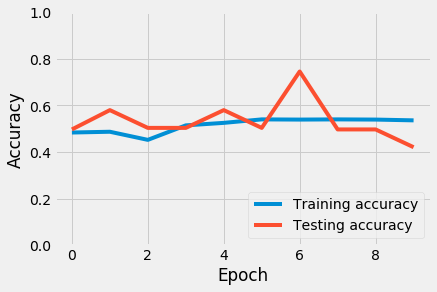

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)

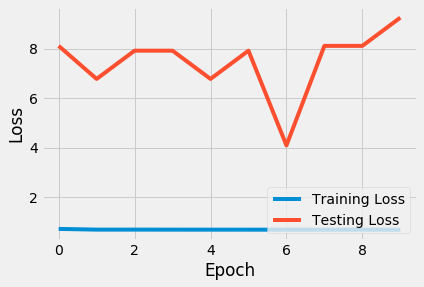

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=4)